## Embedding and Clustering Implementation with MNIST

In [74]:
import random
import math
import itertools
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils import data
from torchvision import datasets

In [75]:
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

device = 'cpu'
same_seed(2023)

### Hyperparameter
`reduce_dim=2` means we want to embed our data to $\mathbb{R}^2$.

In [76]:
n_epoch = 15
batch_size = 32
latent_dim = 32
reduce_dim = 2
n_iter = 1000
lr = 0.0005
model_save = 'model.pth'

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
])

In [78]:
train_set = datasets.MNIST(root='./', train=True,download=True, transform=transform)
                                
test_set = datasets.MNIST(root='./', train=False,download=True, transform=transform)
                                       
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(dataset=train_set, lengths=[train_size, val_size])

train_loader = data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = data.DataLoader(dataset=val_set,batch_size=batch_size,shuffle=True)                               
test_loader = data.DataLoader(test_set, batch_size=batch_size,shuffle=False)  

### Autoencoder
The output of the model is the laten vectors and the reconstructed images.

In [79]:
class autoencoder(nn.Module):
    def __init__(self,latent_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,1,1),  
            nn.MaxPool2d(2,2), #[14,14]
            nn.Conv2d(16,latent_dim,3,1,1), 
            nn.MaxPool2d(2,2), #[7,7]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 16, 2, stride=2), # [14,14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), # [28,28]
            nn.Sigmoid(),
        )
    def forward(self,x):
        latent = self.encoder(x)
        reconstruct = self.decoder(latent)

        return latent,reconstruct

In [80]:
model = autoencoder(latent_dim=latent_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)

### Training and Validation

In [81]:
def Train(train, val, model, device, n_epoch, batch, model_save):
    best_loss = 100
    for epoch in range(n_epoch):
        total_loss = 0

        # Training
        model.train()
        train_loss = []
        idx = 0
        for image, _ in train:
            image = image.to(device, dtype=torch.float)
            _, reconsturct = model(image)
            loss = criterion(reconsturct, image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train)*batch, loss.item()), end='\r')
            idx += 1
        total_loss = sum(train_loss)/len(train)
        print("\n  Training loss:%.4f " % total_loss)

        # Validation
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for image, _ in val:
                image = image.to(device, dtype=torch.float)
                _, reconstruct = model(image)

                loss = criterion(reconstruct, image)
                valid_loss.append(loss.item())
            total_loss = sum(valid_loss)/len(val)
            print(" Validation loss:%.4f " % total_loss)
        # save model
        if total_loss < best_loss:
                best_loss = total_loss
                print("saving model with loss %.4f...\n" % total_loss)
                torch.save(model.state_dict(), "%s" % model_save)

In [82]:
Train(train_loader, valid_loader, model, device, n_epoch, batch_size, model_save)

[Epoch 1 | 53984/54016] loss: 0.5140
  Training loss:0.5162 
 Validation loss:0.4772 
saving model with loss 0.4772...

[Epoch 2 | 53984/54016] loss: 0.4730
  Training loss:0.4754 
 Validation loss:0.4722 
saving model with loss 0.4722...

[Epoch 3 | 53984/54016] loss: 0.5021
  Training loss:0.4723 
 Validation loss:0.4705 
saving model with loss 0.4705...

[Epoch 4 | 53984/54016] loss: 0.4264
  Training loss:0.4710 
 Validation loss:0.4695 
saving model with loss 0.4695...

[Epoch 5 | 53984/54016] loss: 0.4939
  Training loss:0.4702 
 Validation loss:0.4688 
saving model with loss 0.4688...

[Epoch 6 | 53984/54016] loss: 0.4402
  Training loss:0.4697 
 Validation loss:0.4682 
saving model with loss 0.4682...

[Epoch 7 | 53984/54016] loss: 0.4582
  Training loss:0.4693 
 Validation loss:0.4679 
saving model with loss 0.4679...

[Epoch 8 | 53984/54016] loss: 0.4562
  Training loss:0.4689 
 Validation loss:0.4675 
saving model with loss 0.4675...

[Epoch 9 | 53984/54016] loss: 0.4865
  T

### Plot the Reconstructed Images

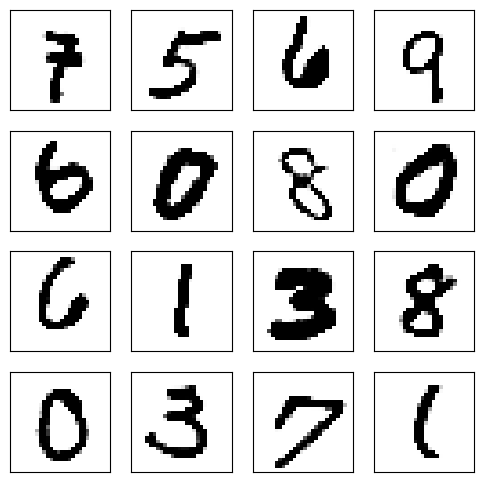

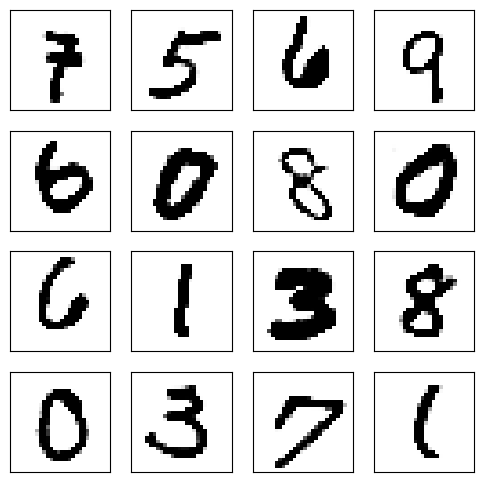

In [84]:
fixed_number_samples = 16

size_figure_grid = int(math.sqrt(fixed_number_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
model.load_state_dict(torch.load(model_save))
model.eval()

for batch_idx, samples in enumerate(train_loader):
    if batch_idx==0:
        img, _ = samples
    _, reconstruct = model(img)
    for k in range(fixed_number_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(reconstruct[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

### Clustering Process

In [85]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]

    model.eval()
    latent_vector = torch.tensor([]).to(device, dtype=torch.float)
    for image, _ in loader:
        image = image.to(device, dtype=torch.float)
        latent, _ = model(image)
        latent_vector = torch.cat((latent_vector, latent), dim=0)

    latent_vector = latent_vector.cpu().detach().numpy()

    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vector = latent_vector.reshape(batch_size,-1)
        latent_vector = tsne.fit_transform(latent_vector)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vector = latent_vector.reshape(batch_size,-1)
        latent_vector = pca.fit_transform(latent_vector)

    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vector)
    return latent_vector,kmeans.labels_

In [86]:
model.load_state_dict(torch.load(model_save))
predicted_tsne = clustering(model, device, test_loader, n_iter, reduced_method='tsne', reduced_dim=reduce_dim, perplexity=10)
predicted_pca = clustering(model, device, test_loader, n_iter, reduced_method='pca', reduced_dim=reduce_dim, perplexity=10)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 420.963478
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.349010
[t-SNE] KL divergence after 1000 iterations: 0.079663


/Users/lerong/miniconda3/envs/general_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/lerong/miniconda3/envs/general_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Plot the Results
The blue points are the embedded points from t-SNE, where the top left points are labeled 1, and the bottom right points are labeled 0. On the other hand, the orange points are the embedded points from PCA. The distribution of embedded points illustrate the comparison of these two embedding scheme. T-SNE, at least in this scenario, is better than PCA.

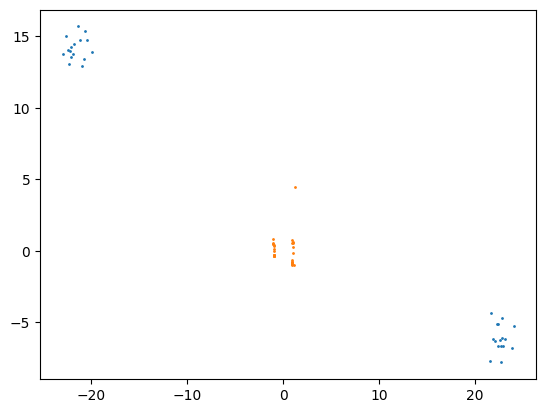

In [87]:
# Blue: t-SNE, Orange: PCA
plt.scatter(x=predicted_tsne[0][:,0],y=predicted_tsne[0][:,1],s=1)
plt.scatter(x=predicted_pca[0][:,0],y=predicted_pca[0][:,1],s=1)

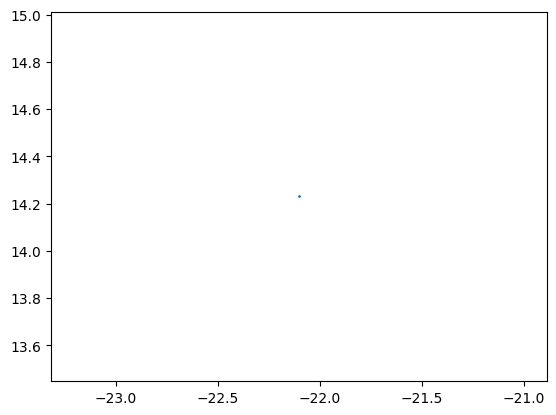

In [90]:
plt.scatter(x=predicted_tsne[0][0,0],y=predicted_tsne[0][0,1],s=1)

In [88]:
predicted_tsne[1]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

In [89]:
predicted_pca[1]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)